# Assignment 2

The assignment 2 contains 3 questions and the due date is May 1 (Monday) 23:59PM.

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, mean_absolute_percentage_error
import time

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

## Question 1 Image Compression

In this question, you will work with images and apply KMeans for image compression, by reducing the number of colours that occur in an image to only those that are most common in that image.


### Question 1.1 (0 points)

To let you learn how Python work with images, plese complete this question.

### Black & white images

Each images represent a matrix where each pixel is an element of this matrix 
<img src="https://miro.medium.com/max/1386/1*bV7S0zACdidh11ikjYpLpQ.png">
The scale of colors is between 0 and 255 : 0 correspond to black and 255 to white

### Colored images
<img src="https://miro.medium.com/max/840/1*y0nV4cWk3KbzXSe9dIWL5g.jpeg">

Every color is a linear combinaison of primary colors : Red Green Blue <br/>
A colored image is somehow just the supperposition of three images : for each pixel with have three values




### Download images

We are using the famous [The CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) that consists of 60000 32x32 color images in 10 classes, with 6000 images per class. We need to donwload this dataset from tensorflow. If you have not installed tensorflow, please follow the [instllation guide](https://www.tensorflow.org/install) to get it or simply use Google colab for this assignment.




In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

By checking the shape, you will find the train set contains 50,000 images with the shape of (32, 32, 3) that indicates the image resolution with 3 color channels.

In [4]:
x_train.shape

(50000, 32, 32, 3)

You can visually check a random image:

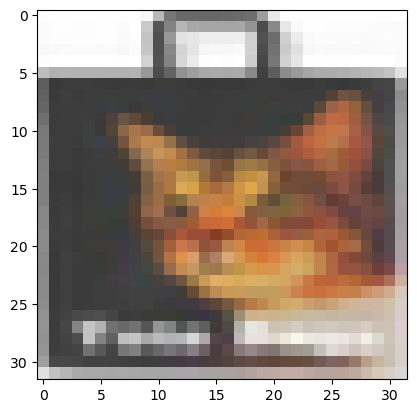

In [5]:
plt.imshow(x_train[3000])

We can also check the image at each of three channels:

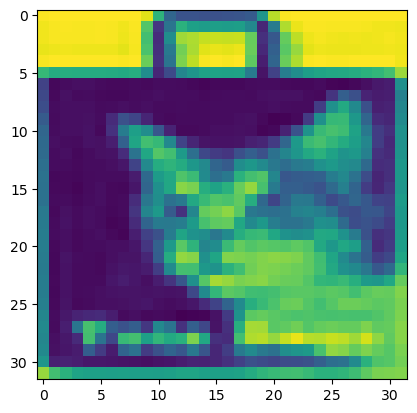

In [6]:
plt.imshow(x_train[3000][:, :, 0]) # red channel

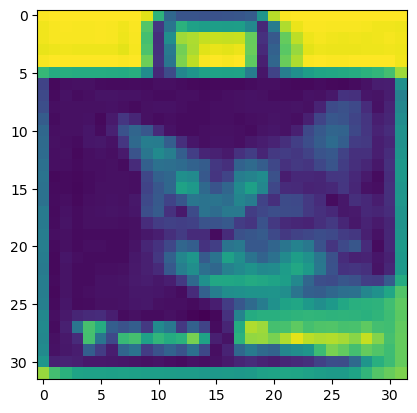

In [7]:
plt.imshow(x_train[3000][:, :, 1]) # green channel

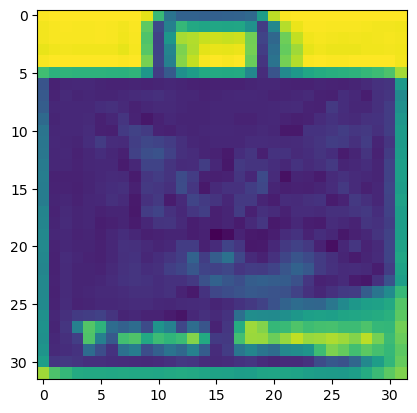

In [8]:
plt.imshow(x_train[3000][:, :, 2]) # blue channel

We can convert a color image as a greyscale image using the NTSC formula: 0.299 ∙ Red + 0.587 ∙ Green + 0.114 ∙ Blue. This formula closely represents the average person's relative perception of the brightness of red, green, and blue light.

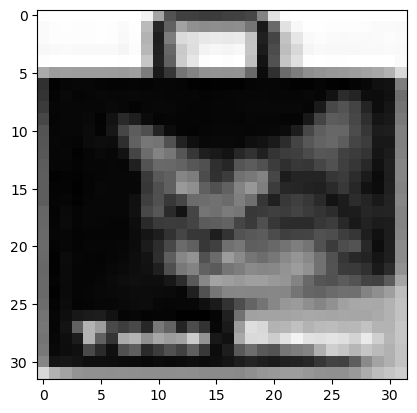

In [9]:
R, G, B = x_train[3000][:,:,0], x_train[3000][:,:,1], x_train[3000][:,:,2]
imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
plt.imshow(imgGray, cmap='gray')

### Question 1.2 (10 points)

Convert all color images in x_train into greyscale images and use the sklearn.decomposition.PCA to perform principal component analysis to the dataset to reduce dimensions to 256. Then, reconstruct images from its reduced representation. Choose a image and see how it goes before and after the PCA using imread method. Explain your findings.  

**Hint** You may need to use numpy's reshape method to change the representation of each image as a vector before performing PCA and reshape it back as an image before you are able to visualize it.

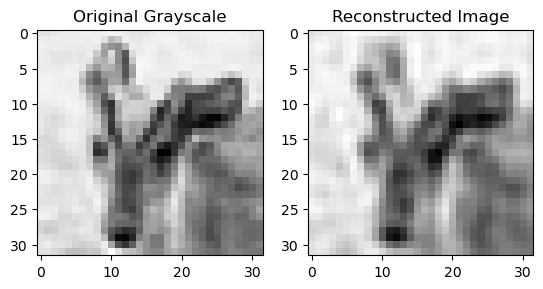

In [10]:
# Convert all color images in x_train to grayscale
def rgb2gray(img):
    R, G, B = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    img_gray = 0.2989 * R + 0.5870 * G + 0.1140 * B
    return img_gray

# resulting shape (50000, 32, 32)
x_train_gray = np.array([rgb2gray(img) for img in x_train])

# Reshape the images into 1D vectors, unfolding each of the 50000 images into a long row of pixel values
# resulting shape (50000, 1024)
x_train_gray_flat = x_train_gray.reshape(x_train_gray.shape[0], -1)

# Perform PCA to reduce dimensionality to 256
pca = PCA(n_components=256)
x_train_pca = pca.fit_transform(x_train_gray_flat)

# Reconstruct images from their reduced representation
x_train_inv = pca.inverse_transform(x_train_pca) # shape (50000, 1024)

# Reshape 1D vectors back to original 2D shape (32x32 pixels)
x_train_inv = x_train_inv.reshape(x_train_gray.shape) # shape (50000, 32, 32)

# Choose an image index to compare before and after PCA
image_index = 3001

# Plot original grayscale image
plt.subplot(1, 2, 1)
plt.imshow(x_train_gray[image_index], cmap='gray')
plt.title('Original Grayscale')

# Plot reconstructed image after PCA
plt.subplot(1, 2, 2)
plt.imshow(x_train_inv[image_index], cmap='gray')
plt.title('Reconstructed Image')

plt.show()

<span style="color:orange">**Findings:**</span> 
We can see that the original image and the reconstructed image are not the same, but the content of the picture is still observable.

- PCA is applied to the flattened grayscale images to reduce their dimensionality from 1024 to 256. This is done to reduce the computational complexity and storage requirements, while still retaining the most important features of the images.
- After applying PCA, the images are reconstructed from their reduced representation to the original space via inverse_transform. This is done by applying the inverse PCA transformation. The reconstructed images will be an approximation of the original images, but with some loss of information due to the dimensionality reduction.

We have lost information by reducing the dimensions with PCA, and we cannot go back to the origina data with reconstruction. Therefore the quality of the reconstructed image is lower.

### Question 1.3 (10 points)

Now explain which number of principal components should be chosen using Elbow method if PCA reaches 90% threshold of explained variance. Use the obtained number of principal components to reduce the image dimensions and again compare the reconstructed images from the previous step. Expalin your findings.

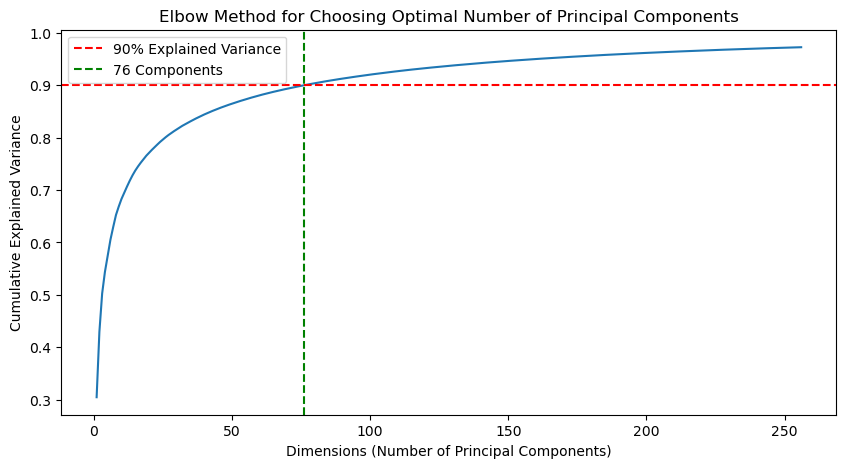

In [11]:
# Performs PCA without reducing dimensionality
pca_full = PCA()
pca_full.fit(x_train_gray_flat)

# Calculate the cumulative explained variance
# explained variance ratio = percentage of variance that is attributed by each of the selected components
# add the explained variance ratio of each component
cumsum = np.cumsum(pca.explained_variance_ratio_)

# find number of components where explained variance reaches 90%
d = np.argmax(cumsum >= 0.90) + 1

# plot the elbow method
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumsum) + 1), cumsum) # x, y
plt.xlabel('Dimensions (Number of Principal Components)')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Explained Variance')
plt.axvline(x=d, color='g', linestyle='--', label=f'{d} Components')
plt.legend()
plt.title('Elbow Method for Choosing Optimal Number of Principal Components')
plt.show()

<span style="color:orange">**Findings:**</span>
One important challenge in PCA is how to determine the number of components to retain.

We tried to find the number of components by using the elbow method and calculating the cumulative explained variance.
- an "elbow" is a sharp change in the slopes of adjacent line segments. The graph will usually level of at some point, since in the beginning, the top principal components will represent a lot of information, while the the other ones will have less information.
- by plotting the number of components against the cumulative explained variance ratio, we can see which number of components cumulatively explain a certain percentage of variation. 

We found out that the number of components where the explained variance reaches 90% is 76. This is the number k of principal components that should be chosen.

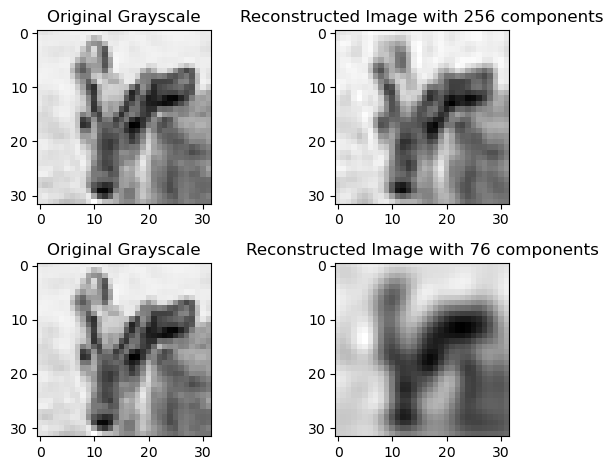

In [12]:
# Perform PCA to reduce dimensionality to optimal number of components
pca_opt = PCA(n_components=d)
x_train_pca_opt = pca_opt.fit_transform(x_train_gray_flat)

# Reconstruct images from their reduced representation
x_train_inv_opt = pca_opt.inverse_transform(x_train_pca_opt) # shape (50000, 1024)

# Reshape 1D vectors back to original 2D shape (32x32 pixels)
x_train_inv_opt = x_train_inv_opt.reshape(x_train_gray.shape) # shape (50000, 32, 32)

# Choose an image index to compare before and after PCA
image_index = 3001

# Plot original grayscale image
plt.subplot(2, 2, 1)
plt.imshow(x_train_gray[image_index], cmap='gray')
plt.title('Original Grayscale')

# Plot reconstructed image after PCA with 256 components
plt.subplot(2, 2, 2)
plt.imshow(x_train_inv[image_index], cmap='gray')
plt.title('Reconstructed Image with 256 components')

# Plot original grayscale image in the second row
plt.subplot(2, 2, 3)
plt.imshow(x_train_gray[image_index], cmap='gray')
plt.title('Original Grayscale')

# Plot reconstructed image after PCA with optimal number of components
plt.subplot(2, 2, 4)
plt.imshow(x_train_inv_opt[image_index], cmap='gray')
plt.title(f'Reconstructed Image with {d} components')

plt.tight_layout()
plt.show()

<span style="color:orange">**Findings:**</span>
Comparing the results of the reconstructed images of both PCA with 256 components and 76 components (the appropriate number of components as determined by using elbow method and 90% threshold of variance), we find that the image quality is much lower using 76 components than 256.

This is expected, since fewer components capture less of the total variance in the dataset, which means more information is lost during the reduction process and cannot be fully restored in the reconstruction process.

However, by using the optimal number of components, the computational complexity and storage requirements can be further reduced while still retaining a satisfactory level of image quality.

### Question 1.4 (10 points)

Now build an image classifier of Logistic Regression (with default configuration) to predict the class of images using the original greyscale images and the compressed representations from PCA that explains 90% of variance. Use the 5-fold cross-validation to report the average macro-f1 test score (given this is a balanced dataset) and total fit time. Explain your findings.

Hint: y_train contains the uint8 value and cross-validate would not consider it as the label for classification. You need to convert the y_train into categorical values such that cross-validate would perform multi-class classification.

In [13]:
# Convert y_train to categorical values
y_train_categorical = y_train.ravel()

# Create a Logistic Regression model (with default configuration)
clf = LogisticRegression(random_state=42)

# Define macro-f1 scorer for cross-validation
f1_scorer = make_scorer(f1_score, average='macro')


## Original grayscale images
# Measure the time taken to perform cross-validation on the original grayscale images
original_start_time = time.time()

# Calculate the average macro-F1 test score for the original grayscale images with 5-fold cross-validation
original_f1_scores = cross_val_score(clf, x_train_gray_flat, y_train_categorical, cv=5, scoring=f1_scorer)

# Calculate total fit-time
original_fit_time = time.time() - original_start_time


## Compressed representation of grayscale images (using number of components that explains 90% of variance)
# Measure the time taken to perform cross-validation on the PCA representations
pca_start_time = time.time()

# Calculate the average macro-F1 test score for the PCA representations with 5-fold cross-validation
pca_f1_scores = cross_val_score(clf, x_train_pca_opt, y_train_categorical, cv=5, scoring=f1_scorer)

# Calculate total fit-time
pca_fit_time = time.time() - pca_start_time


# Print results
print("Original Grayscale Images:")
print(f"Average Macro-F1 Score: {np.mean(original_f1_scores):.4f}")
print(f"Total Fit Time: {original_fit_time:.2f} seconds")

print("\nPCA Compressed Representations:")
print(f"Average Macro-F1 Score: {np.mean(pca_f1_scores):.4f}")
print(f"Total Fit Time: {pca_fit_time:.2f} seconds")

Original Grayscale Images:
Average Macro-F1 Score: 0.2772
Total Fit Time: 104.93 seconds

PCA Compressed Representations:
Average Macro-F1 Score: 0.2882
Total Fit Time: 11.98 seconds


<span style="color:orange">**Findings:**</span> 
We built image classifiers of logisitic regression to predict the class of images using the original greyscale images and the compressed representations of PCA with 76 components. Both the total fit time and the average macro-f1 score were calculated. 

**F1 score**

To compare the performance of two classifiers, the F1 score is useful
- **The F1 score**: precision and recall can be combined into a single metric called the F1 score. The F1 score is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.
- **The macro F1 score**: for multi-class classification, need to use either micro or macro F1. Macro F1 score is the unweighted mean of the F1 scores calculated per class.

The average macro-F1 score of the PCA compressed representations is slightly higher (0.2882) than the original grayscale images (0.2772). The higher the (macro) F1 scores, the better. This indicates that the logistic regression model performs better on the compressed representations, despite the dimensionality reduction and potential loss of information.

Reducing dimensionality could prevent overfitting and filter out noise in the data, explaining the slightly higher F1 score. By removing less important features and noise, it might be easier for the model to learn the underlying patterns and generalize better to new data.


**Fit time**

The time taken to perform cross-validation on the original grayscale images is way longer than the time to perform cross-validation on the compressed representation. This shows the computational efficiency of PCA compression.


-> Overall, the classification using the data of PCA Compressed Representations performed better both in terms of fit time and macro F1 score.

### Question 1.5 (15 points)

Now let's work with the color images (with 3 channels) and again compress one image, this time by reducing numbers of colors using K-means. You need to cluster pixel values into **32 clusters** and choose the "mean color" to replace all the pixels in each cluster by this mean color. Show the original color image of cat and the mean color image of the same one. Explain your findings. 

Hint: each color pixel is represented by a 3D (R,G,B) vector, and the image would have 32x32 pixels. So you could find the mean color from the centroids of 32 clusters and update the pixels of image with the mean color.

Hint2: Once you have replaced the pixel values with mean color, you need to explicitly convert it into **uint type** such s uint8, uint16, etc, because the image pixel values can only be represented as integers or fractions.

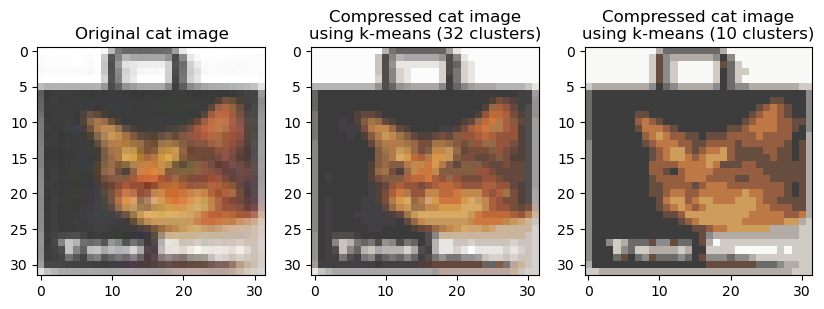

In [191]:
# Compress one image, reducing number of colors using K-means

# Use the image of the cat
img_cat = x_train[3000] # shape (32, 32, 3)

# Reshape the image of cat
width = img_cat.shape[1]
height = img_cat.shape[0]
channels = 3
img_cat_reshaped = img_cat.reshape([width * height, channels]) # shape (1024, 3), one row for each pixel with the 3 channels as columns


## ---- 32 CLUSTERS ---- 
# Initialize Kmeans to cluster pixel values into 32 clusters
kmeans = KMeans(n_clusters=32, random_state=42)

# Train model
kmeans.fit(img_cat_reshaped)

# Replace all pixels in each cluster by mean color
# Indexing kmeans.cluster_centers_ array with kmeans.labels_ creates new array 
# where each pixel value is replaced with the corresponding mean color value of the cluster it belongs to. 
compressed_img = kmeans.cluster_centers_[kmeans.labels_]

# Reshape the image back to its original shape (32, 32, 3)
compressed_img = compressed_img.reshape(height, width, channels)

# Convert the image back to the uint8 type
compressed_img_uint8 = np.clip(compressed_img, 0, 255).astype(np.uint8)


## ---- 15 CLUSTERS ----
# Initialize Kmeans to cluster pixel values into 15 clusters
kmeans2 = KMeans(n_clusters=10, random_state=42)
kmeans2.fit(img_cat_reshaped)
compressed_img2 = kmeans2.cluster_centers_[kmeans2.labels_]
compressed_img2 = compressed_img2.reshape(height, width, channels)
compressed_img2_uint8 = np.clip(compressed_img2, 0, 255).astype(np.uint8)

# Show original image of cat and mean color image of cat
plt.figure(figsize = [10, 10])
plt.subplot(1, 3, 1)
plt.imshow(img_cat)
plt.title('Original cat image')

plt.subplot(1, 3, 2)
plt.imshow(compressed_img_uint8)
plt.title('Compressed cat image\nusing k-means (32 clusters)')

plt.subplot(1, 3, 3)
plt.imshow(compressed_img2_uint8)
plt.title('Compressed cat image\nusing k-means (10 clusters)')
plt.show()

<span style="color:orange">**Findings:**</span> We used k-means clustering to compress a color-image. With k-means, the number of colors in the image was reduced by creating k clusters of pixels, and then replacing the colors of the pixels with the centroid (mean color value) of the cluster.

By comparing the original cat image with the compressed image using 32 clusters, we notice only a very subtle difference in the center of the cat's face, where the red-ish colors appear slightly less prominent.

The difference becomes more pronounced when we choose a smaller number of clusters, such as 10. As the number of clusters decreases, fewer colors are used in the image because fewer clusters are created, leading to a larger number of pixels being assigned to the mean color of each cluster. This results in an image with less detail and more noticeable color differences compared to the original.


## Question 2 Nova SBE Wikipedia 


In this question, you will work with time-series forecasting of page views of [Nova SBE's Wikipedia page](https://en.wikipedia.org/wiki/Nova_School_of_Business_and_Economics)  

When you click 'View history', you should see the backend of the wiki page and you can further select 'Pageviews' to have the statistics of page views of this page. Let's select the page views from all times (July 2015 to April 2023) at monthly level from users only (we exclude robot/spider views) and here is the [link](https://pageviews.wmcloud.org/?project=en.wikipedia.org&platform=all-access&agent=user&redirects=0&start=2015-07&end=2022-07&pages=Nova_School_of_Business_and_Economics) that allows you to get it directly. You can choose to download the data as csv or JSON file to work on.


In [14]:
pageview = pd.read_csv('data/nova-wiki-pageviews.csv')
pageview

,Date,Nova School of Business and Economics
0,2015-07,614
1,2015-08,675
2,2015-09,753
3,2015-10,703
4,2015-11,652
...,...,...
88,2022-11,1252
89,2022-12,887
90,2023-01,1203
91,2023-02,1128


In [15]:
pageview['Date'] = pd.to_datetime(pageview['Date'])
pageview.set_index('Date', inplace=True)

<Axes: xlabel='Date'>

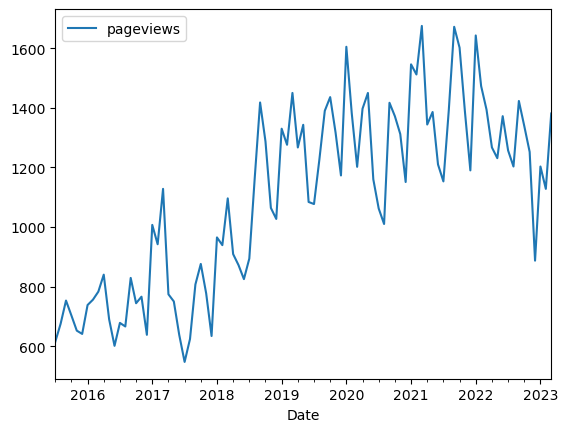

In [16]:
pageview.rename(columns={'Nova School of Business and Economics':'pageviews'}, inplace=True)
pageview.plot()

### Question 2.1 Ensure Stationarity (10 points)

We will perform time-series forecasting and we need to ensure stationarity first. Perform [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html)and explain whether the pageview of wiki pages is stationary and would you be able to stationarize the data through first-order and second-order differencing (you can check the p-value and see if you achieve the statistical significance)?

Alternatively, you could also stationarize the pageview time series through deseasonlization. Perform seasonal decomposition using additive or multiplicative methods and explain whether you would achieve stationary time-series through seasonal decomposition?


#### ADF to test stationary

In [17]:
 # perform Augmented Dick Fuller (ADF) test
 adf_test = adfuller(pageview['pageviews'])
 
 # print results
 print("1. ADF test statistic : ",adf_test[0])
 print("2. P-Value : ", adf_test[1])
 print("3. Number Of Lags used: ", adf_test[2])
 print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", adf_test[3])
 print("5. Critical Values :")
 for key, val in adf_test[4].items():
     print("\t",key, ": ", val) 

1. ADF test statistic :  -1.5443049281085675
2. P-Value :  0.5114916887746873
3. Number Of Lags used:  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 80
5. Critical Values :
	 1% :  -3.5148692050781247
	 5% :  -2.8984085156250003
	 10% :  -2.58643890625


<span style="color:orange">**Findings:**</span> One way to test whether the time series (TS) is stationary is via the Augmented Dick Fuller (ADF) Test.

ADF tests the following null hypothesis:
- H0: The series is not-stationary.

The null hypothesis is rejected if p is less than a significance level (usually < 0.05). If H0 is rejected, we can inferr stationary.
A p-value close to 0 (e.g. p < 0.05) indicates stationarity.

Here, with a p-value of 0.51 (greater than significance level of 0.05) we fail to reject H0, indicating that the TS is non-stationary.

#### Test stationary visually

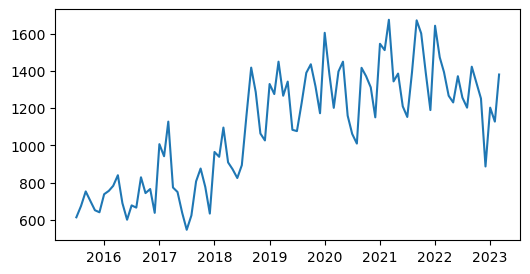

In [18]:
plt.figure(figsize=(6,3))
plt.plot(pageview)
plt.show()

<span style="color:orange">**Findings:**</span> Moreover, one can visually see that the TS is not stationary.
We can see an upwards trend and therefore a changing mean. Time influences the statistical properties of the TS.

#### First-order and second-order differencing: Can we make it stationary?
A trend in the data can be removed by differencing one or more times.
We can apply differencing to our dataset to turn non-stationary data into stationary data. 

First difference: change in value from one period to the next $\Delta Y_t$ = $Y_t$ - $Y_{t-i}$


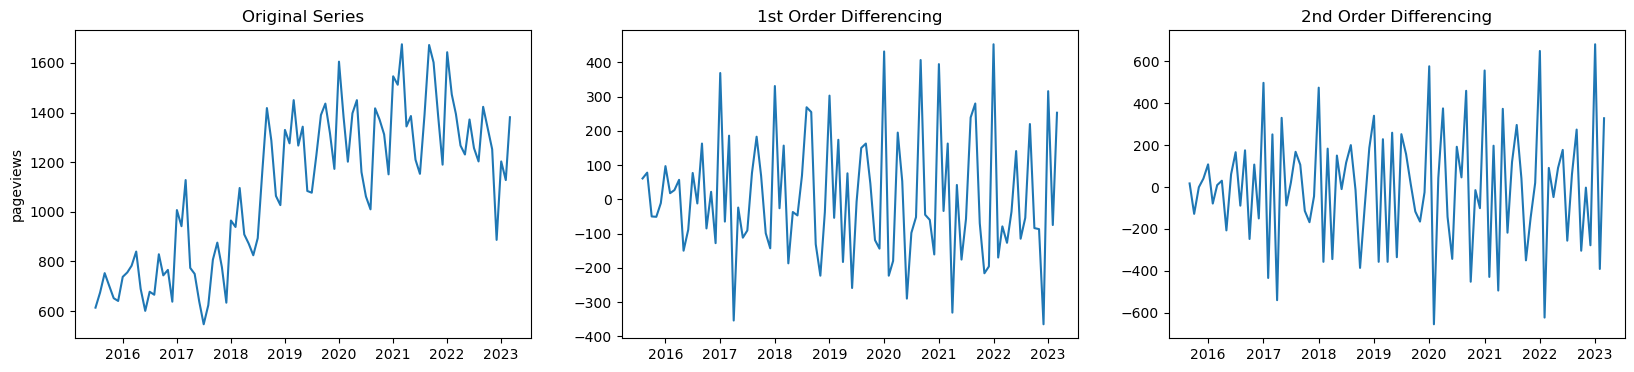

In [19]:
# Plot the original TS and first- and second-order differencing
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))

# Original series
zero_diff = pageview['pageviews']
ax1.plot(zero_diff); ax1.set_title('Original Series')
ax1.set_ylabel('pageviews')

# 1st Differencing
first_order_diff = pageview['pageviews'].diff(1) # shift by one period
ax2.plot(first_order_diff); 
ax2.set_title('1st Order Differencing')

# 2nd Differencing
second_order_diff = first_order_diff.diff(1)
ax3.plot(second_order_diff); 
ax3.set_title('2nd Order Differencing');

In [20]:
# check the p-value to see if we achieve the statistical significance
print('p-value original series: ', adfuller(zero_diff)[1])
print('p-value first-differencing: ', adfuller(first_order_diff.dropna())[1])
print('p-value second-differencing: ', adfuller(second_order_diff.dropna())[1])

p-value original series:  0.5114916887746873
p-value first-differencing:  0.07188845593148703
p-value second-differencing:  2.9297425080936917e-07


<span style="color:orange">**Findings:**</span>
- First-order differencing results in a p-value of 0.07 which is slightly above 0.05
- Second-order differencing results in a p-value very close to 0 and below 0.05, indicating that we can reject the null hypothesis and the resulting series is stationary. 

Therefore, second-order differencing can be used to stationarize the pageview time series. However, since the p-value of 1-diff 0.07 is close to the significance level of 0.05, we could consider to only use one differencing term instead of 2, since with 2-diff we might have exponential behavior and might want to use a log transformation instead! 
Alternatively, we can de-trend and work with the de-trended series without differencing.

In [21]:
# automatically estimate differencing term
ndiffs(zero_diff)

1

#### Stationarize the pageview time series through deseasonalization

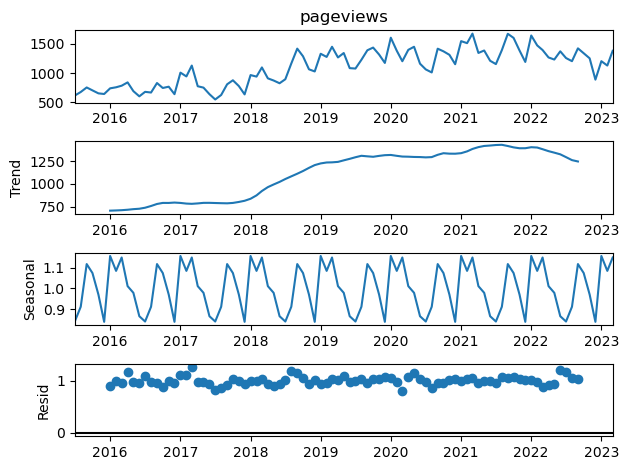

In [22]:
# seasonal decomposition
# multiplicative decomposition (y = Trend * Seasonal * Residuals)
decomposition_mul = seasonal_decompose(pageview['pageviews'], model='multiplicative')
decomposition_mul.plot()
plt.show()

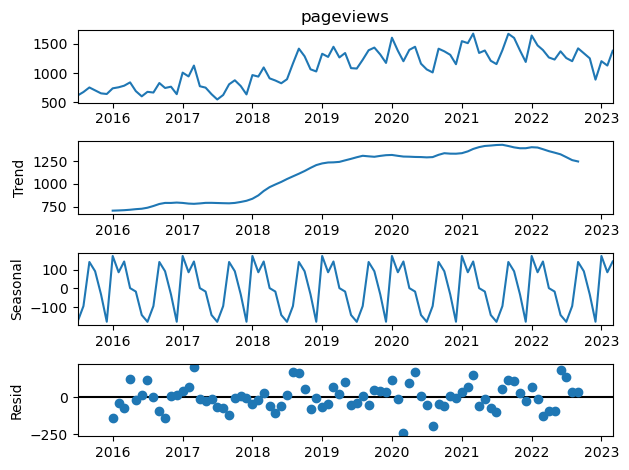

In [23]:
# seasonal decomposition
# additive decomposition (y = Trend + Seasonal + Residuals)
decomposition_add = seasonal_decompose(pageview['pageviews'], model='additive')
decomposition_add.plot()
plt.show()

Text(0.5, 1.0, 'Multiplicative Model Residuals')

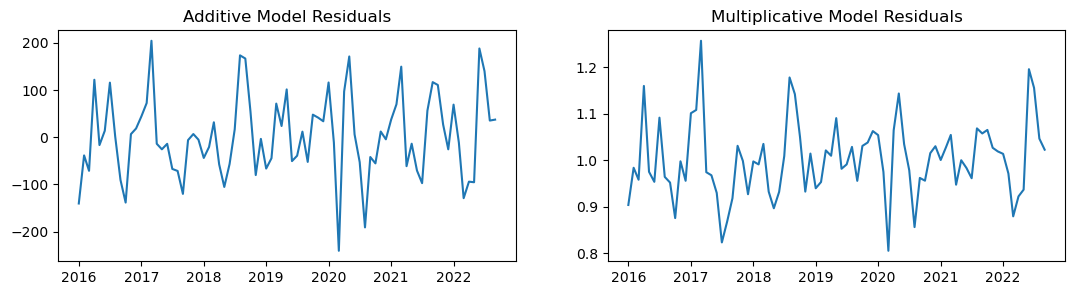

In [25]:
# Plot the residuals with "result_add.resid" to decide
f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,3))

# additive model
ax1.plot(decomposition_add.resid)
ax1.set_title("Additive Model Residuals")

# multiplicative model
ax2.plot(decomposition_mul.resid)
ax2.set_title("Multiplicative Model Residuals")

<span style="color:orange">**Choosing between additive and multiplicative decomposition:**</span>
Generally, can decompose the TS into several components:
- Trend **T**, 
- Seasonality **S**, 
- and Residues **R**.

We can also define if the model decomposes the data in an **additive** or **multiplticative** model. This means you can have your data represented as:
- **additive model**: y = T + S + R
- or **multiplication model**: y = T * S * R


In general:
- The additive model is useful when the seasonal variation is relatively constant over time.
- The multiplicative model is useful when the seasonal variation increases over time.

The residuals plot doesn't tell us a lot for this TS. In our case, the seasonal variation increases only very slightly over time. Therefore, the additive decomposition will be used.

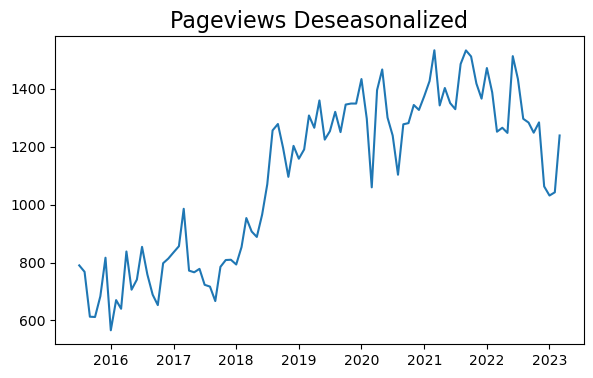

In [26]:
# Let's remove seasons
# In an additive decomposition model, the time series is expressed as the sum of its trend, seasonal, and residual components (y = Trend + Seasonal + Residuals).
# To deseasonalize the data in an additive model, you need to subtract the seasonal component from the original data.
pageview['deseasonalized'] = pageview['pageviews'].values - decomposition_add.seasonal

plt.figure(figsize=(15,4)); 
plt.subplot(1,2,1); 
plt.plot(pageview['deseasonalized']);
plt.title('Pageviews Deseasonalized', fontsize=16);

In [27]:
pageview

,pageviews,deseasonalized
Date,,
2015-07-01,614,790.137483
2015-08-01,675,767.976769
2015-09-01,753,613.036293
2015-10-01,703,612.078952
2015-11-01,652,683.634507
...,...,...
2022-11-01,1252,1283.634507
2022-12-01,887,1062.578952
2023-01-01,1203,1031.208912


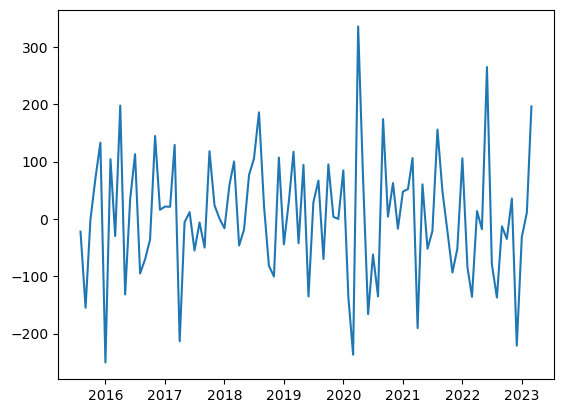

In [28]:
# first order differencing of deseasonalized TS
plt.plot(pageview['deseasonalized'].diff())

In [181]:
# check with ADF Test for stationarity
print('p-value of deseasonalized: ', adfuller(pageview['deseasonalized'])[1])
print('p-value first-diff of deseasonalized: ', adfuller(pageview['deseasonalized'].diff().dropna())[1])

p-value of deseasonalized:  0.47318252894336105
p-value first-diff of deseasonalized:  1.2615375436277728e-13


<span style="color:orange">**Findings:**</span>
The p-value of the deseasonalized dataset 0.47 is greater than 0.05, indicating that we cannot reject the null hypothesis and the resulting series is not stationary. This implies we didn't achieved a stationary time-series through seasonal decomposition, and the hyperparameter d is equal to 1, since we need to apply one difference of deseasonalized until the TS is stationary (close to 0).

### Question 2.2 Identify the hyperparameter (10 points)

Using the method from the previous section, we will preprocess the time series by deseasonalizing it (either additive or multiplicative) and identify the optimal hyperparameter of (p,d,q) for ARIMA model. Explain how would you find these hyperparameters. You could consider plotting autocorrelation and partial autocorrelation functions. 

<span style="color:orange">**How to find the hyperparameters p,d,q:**</span>

Either through plots
- I(d) ~ find d by checking how many orders of differences we need to apply until TS is stationary
- AR(p) ~ find p by plotting the PACF and check the number of lags beyond which the PACF plot of $Y(d)$ cuts off (meaning it drops below the confidence levels (blue cone))
- MA(q) ~ find q by plotting the ACF plot and check the number of lags beyond which the ACF plot of $Y(d)$ cuts off (meaning it drops below the confidence levels (blue cone))

-> Note that for p and q the first lag is ignored, as it represents AC/PAC between $y_t$ and itself

Or via auto-arima
- use pm.auto_arima which performs a step-wise search of best hyperparameters that minimize the AIC (Akaike Information Criterion)

#### Using ACF and PACF

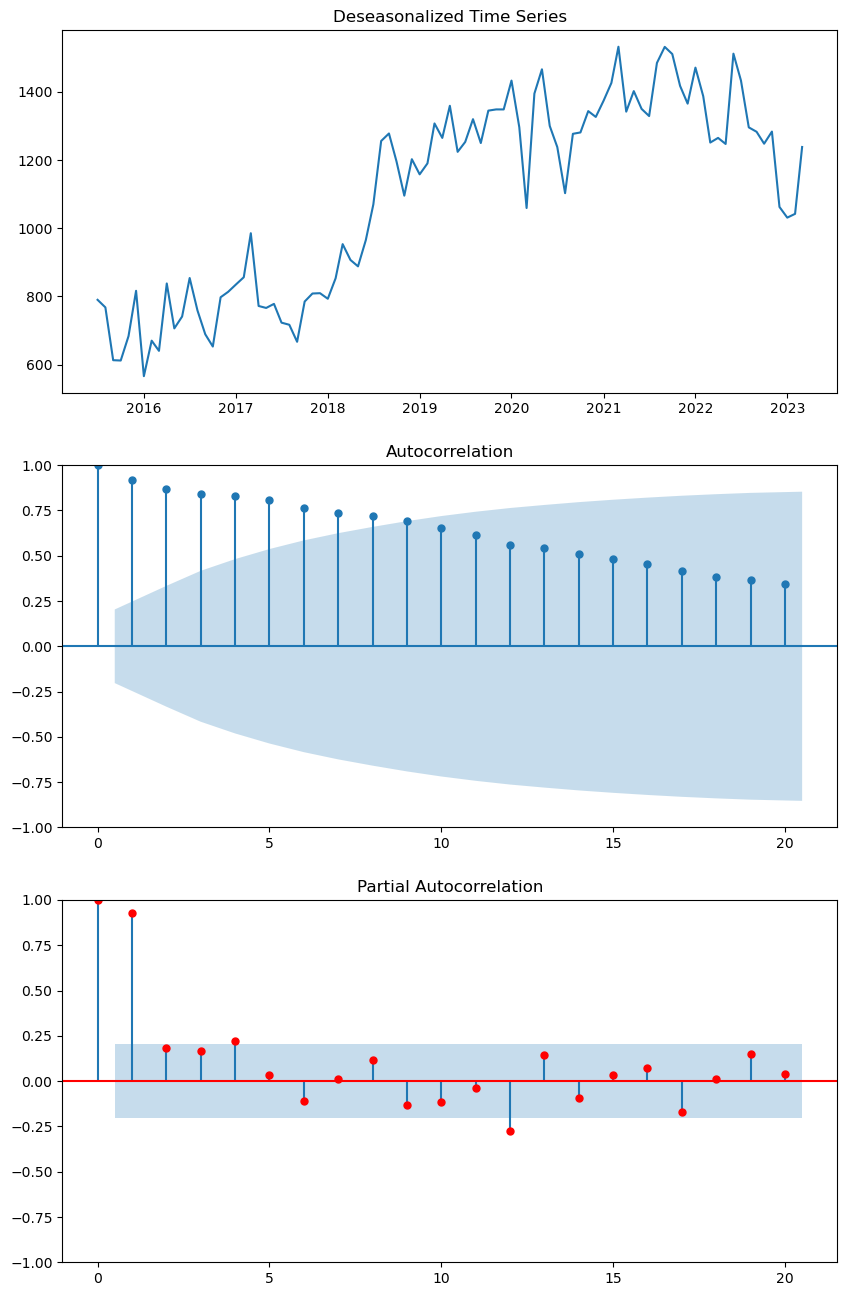

In [29]:
# ACF / PACF analysis of y_diff linearized

# use preprocessed time series
y_deseasonalized = pageview['deseasonalized']

# ACF / PACF analysis of y_diff linearized
fig, axes = plt.subplots(3,1, figsize=(10,16))

# plot the first order diff of deseasonalized data
axes[0].plot(y_deseasonalized); axes[0].set_title('Deseasonalized Time Series')

# plot the ACF
plot_acf(y_deseasonalized, ax=axes[1]);

# plot the PACF
plot_pacf(y_deseasonalized, ax=axes[2], c='r');

<span style="color:orange">**Findings:**</span>
- d ~ we needed to apply one difference until deseasonalized TS is stationary -> d = 1
- p ~ three lags (excluding the first lag) before PACF drops below the confidence levels -> p = 8
- q ~ one lag (excluding the first lag) before the ACF drops below the confidence levels -> q = 1

looking at the plots our model and the previously performed differencing, we would need to use ARIMA(p=8, d=1, q=1)

#### Using auto-arima

In [30]:
smodel = pm.auto_arima(pageview['deseasonalized'],
                       start_p=0, max_p=9,
                       start_q=0, max_q=9,
                       trend='t',
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1126.997, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1125.397, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1121.310, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1126.997, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1119.518, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1119.792, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1120.585, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1118.639, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1120.463, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1122.211, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1118.639, Time=0.12 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.396 seconds


<span style="color:orange">**Findings:**</span>
according to auto-ARIMA the best model, minimizing the AIC, would be ARIMA(p=0, d=1, q=2)

### Question 2.3 Fit and forecast (10 points)

Now let's fit the ARIMA model using the identified hyperparameter of (p,d,q). Let's use the first 80% observations as the train set and remaining 20% observations as the test set 

Once you fit the model on the train set, you can make the forecast on the test set. Use the provided plot_forecast function to visulize the forecasted values and real values (together with 95% confidence interval). 

Lastly, report the mean absolute percentage error on the test set (you can use the sklearn implementation).

Hint: do not forget to add back the seasonality component to reconstruct the original pageview

In [31]:
# We define here a "Plot forecast vs. real", which also shows historical training set

def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

/Users/hannah/opt/anaconda3/envs/master/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/hannah/opt/anaconda3/envs/master/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/hannah/opt/anaconda3/envs/master/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


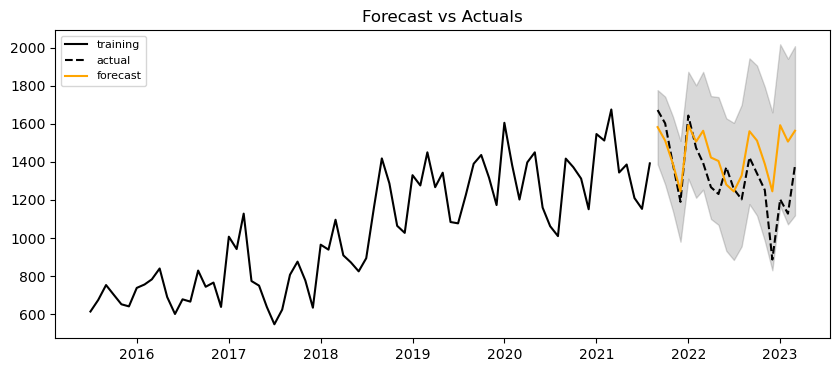

In [33]:
# Create a train_test_split to predict the last 20%
split_index = int(len(pageview) * 0.8)
train = pageview['deseasonalized'][:split_index]
test = pageview['deseasonalized'][split_index:]

# Build model using results of auto-arima
arima = ARIMA(train, order=(0, 1, 2))
arima = arima.fit()

## Forecast
# Forecast values
forecast = arima.forecast(len(test), alpha=0.05)  # 95% confidence

# # Forecast values and confidence intervals
forecast_results = arima.get_forecast(len(test), alpha=0.05)
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values

# Re-compose back to initial TS by adding seasonal data back
forecast_recons = forecast + decomposition_add.seasonal[split_index:]
train_recons = train + decomposition_add.seasonal[:split_index]
test_recons = test + decomposition_add.seasonal[split_index:]
lower_recons = confidence_int[:, 0] + decomposition_add.seasonal[split_index:]
upper_recons = confidence_int[:, 1] + decomposition_add.seasonal[split_index:]

# Plot
plot_forecast(forecast_recons, train_recons, test_recons, lower_recons.values, upper_recons.values)


In [34]:
# Calculate the MAPE
mape = mean_absolute_percentage_error(test_recons, forecast_recons)

# Print the MAPE as a percentage
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

Mean Absolute Percentage Error (MAPE): 12.14%


<span style="color:orange">**Findings:**</span>
Using the hyperparameters found by auto-arima ARIMA(0,1,2), we can see that the forecasted pageviews were close to the actual pageviews for the last 20% of the TS that we used as test set. The forecast follows a very similar shape, only the trend was forecasted to increase more than it actually did.

Common regression metrics, such as MAPE (Mean Absolute Percentage Error, can be used to quantitatively evaluate the predictions. MAPE defines the accuracy of the prediction, and measured the average of the absolute percentage errors between the actual values and the predicted values.

The lower the MAPE, the better, indicating a more accurate forecast. The 12.14% MAPE represents that the average deviation between the forecasted value and actual values was 12.14%.

## Question 3 Birds of a feather sing together


In this question, you will work with movie ratings to build a recommender system just like Netflix, Youtube, etc.


__Load the datasets in three different pandas dataframes `movies`, `tags` and `ratings`.__


In [35]:
movies = pd.read_csv('data/movies.csv')
tags = pd.read_csv('data/tags.csv')
ratings = pd.read_csv('data/ratings.csv')

In [36]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [37]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [38]:
tags[tags["movieId"] == 1]

,userId,movieId,tag,timestamp
629,336,1,pixar,1139045764
981,474,1,pixar,1137206825
2886,567,1,fun,1525286013


In [39]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Let's filter the ratings dataframe, to have only movies that have received a rating:

In [40]:
movies['genres'] = movies['genres'].str.replace('|',' ')
movies = movies[movies.movieId.isin(ratings.movieId.unique().tolist())]
movies.shape

(9724, 3)

In [41]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action Animation Comedy Fantasy
9738,193583,No Game No Life: Zero (2017),Animation Comedy Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action Animation


In [42]:
movies.groupby("movieId").sum()

,title,genres
movieId,,
1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
2,Jumanji (1995),Adventure Children Fantasy
3,Grumpier Old Men (1995),Comedy Romance
4,Waiting to Exhale (1995),Comedy Drama Romance
5,Father of the Bride Part II (1995),Comedy
...,...,...
193581,Black Butler: Book of the Atlantic (2017),Action Animation Comedy Fantasy
193583,No Game No Life: Zero (2017),Animation Comedy Fantasy
193585,Flint (2017),Drama


### Question 3.1 (10 points) Content-based recommender system

We create a new feature called metadata, that merges all the text data information we have about a movie : the genre and the tags. So the merged dataframe should contain at least the following columns: *movieId, title and metadata*.

Then, construct the vectorized reprentation of metadata using sklearn's Countvectorizer to transform the metadata into vectors. Learn the latent matrix from the metadata vector using [truncated SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) with 50 dimensions. With the generated latent matrix, identify the top 10 most relevant movies for **"Toy Story (1995)"** by calculating the cosine similairty and finding movies with the highest similarity score. 



In [43]:
# in the tags df there could be multiple rows for one movie
# join the tags for one movie from several rows into one row
tags_unique = tags.groupby("movieId")["tag"].apply(' '.join).reset_index()
tags_unique

,movieId,tag
0,1,pixar pixar fun
1,2,fantasy magic board game Robin Williams game
2,3,moldy old
3,5,pregnancy remake
4,7,remake
...,...,...
1567,183611,Comedy funny Rachel McAdams
1568,184471,adventure Alicia Vikander video game adaptation
1569,187593,Josh Brolin Ryan Reynolds sarcasm
1570,187595,Emilia Clarke star wars


In [44]:
# use a left join to merge the two dataframes
merged_df = pd.merge(movies, tags_unique, on='movieId', how="left")

# replace NaN values
merged_df['tag'] = merged_df['tag'].fillna('') 

# create metadata column that concatenates genres and tag columns
merged_df["metadata"] = merged_df["genres"].str.cat(merged_df["tag"], sep = " ").str.lower()
merged_df

,movieId,title,genres,tag,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun,adventure animation children comedy fantasy pi...
1,2,Jumanji (1995),Adventure Children Fantasy,fantasy magic board game Robin Williams game,adventure children fantasy fantasy magic board...
2,3,Grumpier Old Men (1995),Comedy Romance,moldy old,comedy romance moldy old
3,4,Waiting to Exhale (1995),Comedy Drama Romance,,comedy drama romance
4,5,Father of the Bride Part II (1995),Comedy,pregnancy remake,comedy pregnancy remake
...,...,...,...,...,...
9719,193581,Black Butler: Book of the Atlantic (2017),Action Animation Comedy Fantasy,,action animation comedy fantasy
9720,193583,No Game No Life: Zero (2017),Animation Comedy Fantasy,,animation comedy fantasy
9721,193585,Flint (2017),Drama,,drama
9722,193587,Bungo Stray Dogs: Dead Apple (2018),Action Animation,,action animation


In [45]:
movies_meta = merged_df[["movieId", "title", "metadata"]]
movies_meta

,movieId,title,metadata
0,1,Toy Story (1995),adventure animation children comedy fantasy pi...
1,2,Jumanji (1995),adventure children fantasy fantasy magic board...
2,3,Grumpier Old Men (1995),comedy romance moldy old
3,4,Waiting to Exhale (1995),comedy drama romance
4,5,Father of the Bride Part II (1995),comedy pregnancy remake
...,...,...,...
9719,193581,Black Butler: Book of the Atlantic (2017),action animation comedy fantasy
9720,193583,No Game No Life: Zero (2017),animation comedy fantasy
9721,193585,Flint (2017),drama
9722,193587,Bungo Stray Dogs: Dead Apple (2018),action animation


Then, construct the vectorized reprentation of metadata using sklearn's Countvectorizer to transform the metadata into vectors. Learn the latent matrix from the metadata vector using [truncated SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) with 50 dimensions. With the generated latent matrix, identify the top 10 most relevant movies for **"Toy Story (1995)"** by calculating the cosine similairty and finding movies with the highest similarity score. 


In [46]:
# create a vectorized representation of the metadata column with countvectorizer
vectorizer = CountVectorizer()
metadata_matrix = vectorizer.fit_transform(movies_meta["metadata"])

# Reduce dimensionality using TruncatedSVD with 50 dimensions
svd = TruncatedSVD(n_components=50, random_state=42)
latent_matrix = svd.fit_transform(metadata_matrix)

# Calculate cosine similarity for the latent matrix
cosine_sim_content = cosine_similarity(latent_matrix)

def get_recommendations(title):
    # Get the index of the movie that matches the title
    movie_index = movies_meta[movies_meta['title'] == title].index[0]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim_content[movie_index]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

   # Get the scores of the 11 most similar movies (including the input movie)
    top_11_movies = sim_scores[:11]

    # Get top 10 movie titles, metadata, and similarity scores, excluding the input movie
    top_10_movie_info = [(movies_meta.iloc[movie[0]]['title'], movie[1], movies_meta.iloc[movie[0]]['metadata'])
                         for movie in top_11_movies if movies_meta.iloc[movie[0]]['title'] != title]

    # Create a dataframe for the top 10 movies, their similarity scores, and metadata
    top_10_movies_df = pd.DataFrame(top_10_movie_info, columns=['Movie Title', 'Similarity Score', 'Metadata'])

    # Return the top 10 most similar movies
    return top_10_movies_df

get_recommendations("Toy Story (1995)")

,Movie Title,Similarity Score,Metadata
0,Antz (1998),0.994193,adventure animation children comedy fantasy
1,"Adventures of Rocky and Bullwinkle, The (2000)",0.994193,adventure animation children comedy fantasy
2,"Emperor's New Groove, The (2000)",0.994193,adventure animation children comedy fantasy
3,"Monsters, Inc. (2001)",0.994193,adventure animation children comedy fantasy
4,"Wild, The (2006)",0.994193,adventure animation children comedy fantasy
5,Shrek the Third (2007),0.994193,adventure animation children comedy fantasy
6,"Tale of Despereaux, The (2008)",0.994193,adventure animation children comedy fantasy
7,Asterix and the Vikings (Astérix et les Viking...,0.994193,adventure animation children comedy fantasy
8,Turbo (2013),0.994193,adventure animation children comedy fantasy
9,The Good Dinosaur (2015),0.994193,adventure animation children comedy fantasy


<span style="color:orange">**Findings:**</span>
we can see that the top 10 movies have the same similarity score. The genres of the movies are exactly the same and the top 10 movies didn't have any tags.

### Question 3.2 (10 points) Collaborative filtering recommender system

Similarly, let's creat a latent matrix for ratings and also show the top 10 most relevant movies that receive similar ratings. 

<span style="color:orange">**Item-based CF:**</span> 
There are different types of collaborative filtering (CF) recommender systems. 

- **User-based CF algorithms**: focus on finding similar users based on their movie ratings. 
- **Item-based CF algorithms**: focus on finding movies most similar to the target item using past ratings from other users.

Since we were asked to find movies with similar ratings to Toy Story, it's appropriate to use movie-user collaborative filtering (user-item interaction matrix). For item-based CF, the pivot_table needs to be created in a way that movieIds are in the rows and userIds in the columns.

In [47]:
# Create a pivot table with movieIds as rows, userIds as columns, and ratings as values
movie_user_matrix = ratings.pivot_table(index='movieId', columns='userId', values='rating').fillna(0)

# Apply Truncated SVD to reduce dimensions to 50
svd = TruncatedSVD(n_components=50)
latent_matrix = svd.fit_transform(movie_user_matrix)

# Compute cosine similarity between movies
cosine_sim_collab = cosine_similarity(latent_matrix)

cosine_sim_df = pd.DataFrame(cosine_sim_collab)
cosine_sim_df # shape (9724, 9724)

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,1.000000,0.698216,0.520017,0.241919,0.600464,0.594526,0.533281,0.305135,0.430184,0.628968,...,0.035137,0.035137,0.035137,0.035137,0.035137,0.035137,0.035137,0.035137,0.035137,0.122871
1,0.698216,1.000000,0.555794,0.389129,0.558565,0.461749,0.529817,0.427667,0.178374,0.682294,...,0.102076,0.102076,0.102076,0.102076,0.102076,0.102076,0.102076,0.102076,0.102076,0.076674
2,0.520017,0.555794,1.000000,0.485649,0.754981,0.483502,0.724779,0.414594,0.574714,0.487212,...,-0.065804,-0.065804,-0.065804,-0.065804,-0.065804,-0.065804,-0.065804,-0.065804,-0.065804,0.039989
3,0.241919,0.389129,0.485649,1.000000,0.611950,0.344470,0.688210,0.340674,0.404362,0.272229,...,0.005648,0.005648,0.005648,0.005648,0.005648,0.005648,0.005648,0.005648,0.005648,0.054708
4,0.600464,0.558565,0.754981,0.611950,1.000000,0.472353,0.828045,0.385602,0.659841,0.416523,...,0.070624,0.070624,0.070624,0.070624,0.070624,0.070624,0.070624,0.070624,0.070624,0.050009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.035137,0.102076,-0.065804,0.005648,0.070624,-0.025106,0.019990,-0.053151,0.037711,-0.075735,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.137973
9720,0.035137,0.102076,-0.065804,0.005648,0.070624,-0.025106,0.019990,-0.053151,0.037711,-0.075735,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.137973
9721,0.035137,0.102076,-0.065804,0.005648,0.070624,-0.025106,0.019990,-0.053151,0.037711,-0.075735,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.137973
9722,0.035137,0.102076,-0.065804,0.005648,0.070624,-0.025106,0.019990,-0.053151,0.037711,-0.075735,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.137973


In [48]:
movie_user_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
def get_recommendations(title):
    # Get the index of the movie that matches the title
    movie_index = movies_meta[movies_meta['title'] == title].index[0]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim_collab[movie_index]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 11 most similar movies (including the input movie)
    top_11_movies = sim_scores[:11]

    top_10_movie_info = [(movies_meta.iloc[movie[0]]['title'], movie[1])
                            for movie in top_11_movies if movies_meta.iloc[movie[0]]['title'] != title]

    top_10_movies_df = pd.DataFrame(top_10_movie_info, columns=['Movie Title', 'Similarity Score between movies'])
    return top_10_movies_df

get_recommendations("Toy Story (1995)")

,Movie Title,Similarity Score between movies
0,Jurassic Park (1993),0.802687
1,Independence Day (a.k.a. ID4) (1996),0.798320
2,Willy Wonka & the Chocolate Factory (1971),0.787582
3,Mission: Impossible (1996),0.784771
4,Toy Story 2 (1999),0.784548
5,Groundhog Day (1993),0.775421
6,Forrest Gump (1994),0.759842
7,Aladdin (1992),0.759560
8,"Lion King, The (1994)",0.757583
9,Twister (1996),0.754992


### Question 3.3 (5 points) Hybrid recommender system

Similarly, let's build a hybrid recommender system and also show the top 10 most relevant movies that calculate the average measure of both content and collaborative.


In [52]:
def get_recommendations(title, content_weight=0.5, collab_weight=0.5):
    # Get the index of the movie that matches the title
    movie_index = movies_meta[movies_meta['title'] == title].index[0]

    # Calculate the weighted average of the similarity scores
    weighted_sim_scores = content_weight * cosine_sim_content[movie_index] + \
                          collab_weight * cosine_sim_collab[movie_index]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(weighted_sim_scores))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 11 most similar movies (including the input movie)
    top_11_movies = sim_scores[:11]

    # Get top 10 movie titles and similarity scores, excluding the input movie
    top_10_movie_info = [(movies_meta.iloc[movie[0]]['title'], movie[1])
                            for movie in top_11_movies if movies_meta.iloc[movie[0]]['title'] != title]

    # Create a dataframe for the top 10 movies and their similarity scores
    top_10_movies_df = pd.DataFrame(top_10_movie_info, columns=['Movie Title', 'Weighted Similarity Score'])

    # Return the top 10 most similar movies
    return top_10_movies_df

get_recommendations("Toy Story (1995)")


,Movie Title,Weighted Similarity Score
0,"Monsters, Inc. (2001)",0.859984
1,Toy Story 2 (1999),0.824289
2,Shrek (2001),0.819933
3,"Bug's Life, A (1998)",0.818042
4,Finding Nemo (2003),0.779585
5,Aladdin (1992),0.764805
6,Antz (1998),0.758195
7,Toy Story 3 (2010),0.744436
8,Ice Age (2002),0.739511
9,"Emperor's New Groove, The (2000)",0.734996
